In [4]:
#Built me pytorch ANN that uses a a scikit wrapper for the pytorch model
#The model should have the following structure: hiddenlayers: 35, neuron per hidden layer: 110, optimizer: 'adamW', learning rate: 0.001, regularization:0.3
#The activation function should be leaky relu for the hidden layers and linear for the output layer. The input layer should have 146 neurons and the output layer should have 1 neuron
#The loss function is mse and the metric is mae, rmse and MAPE
#use NeuralNetRegressor from skorch to build the model
#epochs=150, batch_size=64

#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#load the data
data = pd.read_csv('one_hot_encoded.csv')



#split the data into features and target
X = data.drop('claim', axis=1)

feature_names = list(X.columns)

y = data['claim']

#split the data into training and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=69)
# Second split: Split the 40% temporary set into 25% test and 15% evaluation
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=(0.25/0.4), random_state=69)

print(X_train.shape, y_train.shape)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_eval = scaler.transform(X_eval)
X_test = scaler.transform(X_test)


print(X_train.shape, y_train.shape)
#print datatypes
print(X_train.dtype, y_train.dtype)
#print the type of list
print(type(X_train), type(y_train))


(8188, 146) (8188,)
(8188, 146) (8188,)
float64 float64
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the model class
class PyTorchModel(nn.Module):

        
    def __init__(self, input_dim, hidden_layers, neurons, optimizer, learning_rate, regularization):
        super(PyTorchModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.neurons = neurons
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.regularization = regularization
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, neurons))
        self.layers.append(nn.ReLU())
        
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(neurons, 1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
# Function to calculate MAE
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

#convert y from pandas series to numpy array
y_train = np.asarray(y_train)
y_eval = np.asarray(y_eval)
y_test = np.asarray(y_test)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_eval, dtype=torch.float32), torch.tensor(y_eval, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the PyTorch model
input_dim = X_train.shape[1]
hidden_layers = 35
neurons = 110
optimizer_name = 'adamW'
learning_rate = 0.001
regularization = 0.01

model = PyTorchModel(input_dim, hidden_layers, neurons, optimizer_name, learning_rate, regularization)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming this is a regression task, change if necessary

if optimizer_name.lower() == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
elif optimizer_name.lower() == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=regularization)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Training loop
num_epochs = 300

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running_loss to zero at the start of each epoch

    # Iterate over batches of data from train_loader
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.view(-1, 1))  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item()
    
    print(f"Validation Loss: {val_loss/len(val_loader)}")

# Evaluate on the training set
model.eval()
train_predictions = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predictions.extend(outputs.numpy())
train_predictions = np.array(train_predictions).flatten()
y_train_flat = np.array(y_train).flatten()  # Flatten if necessary
train_rmse = calculate_rmse(y_train_flat, train_predictions)

# Evaluate on the test set
test_predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.numpy())
test_predictions = np.array(test_predictions).flatten()
y_test_flat = np.array(y_test).flatten()  # Flatten if necessary
test_rmse = calculate_rmse(y_test_flat, test_predictions)
test_mae = calculate_mae(y_test_flat, test_predictions)
test_mape = calculate_mape(y_test_flat, test_predictions)

# Print RMSE, MAE, and MAPE values
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}%")

Epoch [1/300], Loss: 226412460.21875
Validation Loss: 73153331.5
Epoch [2/300], Loss: 42652369.375
Validation Loss: 42007894.1875
Epoch [3/300], Loss: 35264990.078125
Validation Loss: 87177802.75
Epoch [4/300], Loss: 35191326.4921875
Validation Loss: 25521649.78125
Epoch [5/300], Loss: 22975648.4375
Validation Loss: 27965214.46875
Epoch [6/300], Loss: 20602228.02734375
Validation Loss: 24217412.3125
Epoch [7/300], Loss: 18869656.7890625
Validation Loss: 22254334.40625
Epoch [8/300], Loss: 22245996.5234375
Validation Loss: 26327076.875
Epoch [9/300], Loss: 16565888.12890625
Validation Loss: 22513523.40625
Epoch [10/300], Loss: 13922287.484375
Validation Loss: 23506195.0625
Epoch [11/300], Loss: 14530015.59765625
Validation Loss: 24895537.0
Epoch [12/300], Loss: 13855916.90234375
Validation Loss: 23569334.84375
Epoch [13/300], Loss: 10502125.13671875
Validation Loss: 22811241.09375
Epoch [14/300], Loss: 9613184.42578125
Validation Loss: 22197088.765625
Epoch [15/300], Loss: 7836442.34960

In [149]:
#get X-tensor of train_dataset
X_tensor = train_dataset.tensors[0]
y_tensor = train_dataset.tensors[1]

print(X_tensor)
print(y_tensor)


tensor([[-0.8955, -0.3409, -0.1685,  ..., -0.2325, -0.2985, -0.1385],
        [-0.3985,  0.9100, -0.1522,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.8795,  1.1308,  2.8334,  ..., -0.2325, -0.2985, -0.1385],
        ...,
        [-0.6115, -1.5183, -0.7202,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.4535, -0.1202,  0.5617,  ..., -0.2325, -0.2985, -0.1385],
        [ 1.3765, -0.9296, -0.2334,  ..., -0.2325, -0.2985, -0.1385]])
tensor([18246.5000,  6184.2998,  9748.9004,  ...,  4934.7002,  8824.0000,
        12129.5996])


In [175]:
torch.no_grad()


#convert to tensor
example_instance = X.iloc[40]
print(example_instance)
example_instance = scaler.transform([example_instance])
print(example_instance)
example_instance = torch.tensor(example_instance, dtype=torch.float32)
print(example_instance)


print(model(example_instance).item())
print(y.iloc[40])


age                     18.0
weight                  41.0
bmi                     26.7
no_of_dependents         0.0
smoker                   0.0
                        ... 
job_title_Police         0.0
job_title_Politician     0.0
job_title_Singer         1.0
job_title_Student        0.0
job_title_Technician     0.0
Name: 40, Length: 146, dtype: float64
[[-1.53444884 -1.73906248 -0.57412949 -0.91432184 -0.49223989  0.79259407
   0.52174589  1.87185747  0.97825302 -0.97825302 -0.0948456  -0.07679066
  -0.0799459  -0.10423146 -0.06737448 -0.09679275 -0.08223486 -0.06737448
   0.26174611 -0.08519369 -0.14027193 -0.08663628 -0.11119351 -0.0664537
  -0.09218776 -0.10482848 -0.13799164 -0.08875749 -0.10119581 -0.09807016
  -0.08071591 -0.11615407 -0.14778197 -0.13799164 -0.09151166 -0.08805593
  -0.08945373 -0.09218776 -0.0954989  -0.11882506 -0.08298418 -0.07916859
  -0.08875749 -0.09743347 -0.09614792 -0.11342362 -0.12298462 -0.08591792
  -0.13093073 -0.0948456  -0.13189248 -0.07916859 -0

C:\Users\kobra\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [168]:
import shap
shap.initjs()
#use deep explainer

torch.no_grad()

In [169]:
e = shap.DeepExplainer(model, X_tensor)
print(e)




In [170]:
shap_values = e.shap_values(example_instance, check_additivity=False)
print(shap_values)

print(shap_values.sum())


[[[-4.49413672e+03]
  [-3.81681946e+02]
  [-4.95976929e+02]
  [-1.03289111e+03]
  [-2.09805664e+03]
  [-2.96007629e+02]
  [-6.20932579e+01]
  [-3.51320587e+02]
  [ 4.62670593e+01]
  [ 7.46580734e+01]
  [-7.23073730e+01]
  [-5.20951157e+01]
  [-3.71669884e+01]
  [-6.59923248e+01]
  [-3.12310810e+01]
  [-5.25342484e+01]
  [-7.02436752e+01]
  [-2.01698074e+01]
  [-5.51385040e+01]
  [-4.70498695e+01]
  [-1.34917984e+01]
  [-1.11814604e+01]
  [-1.14574480e+01]
  [-3.56921864e+00]
  [-5.49905062e+00]
  [-4.68524361e+00]
  [-6.63437986e+00]
  [-9.36048687e-01]
  [-1.07738972e+01]
  [-1.00774550e+00]
  [-7.69281578e+00]
  [-6.76137269e-01]
  [-7.09660244e+00]
  [-1.26145487e+01]
  [-5.28334951e+00]
  [-2.46084988e-01]
  [-5.46553469e+00]
  [-1.03789606e+01]
  [-9.39595461e-01]
  [-5.32020235e+00]
  [-3.91437197e+00]
  [-6.84959888e+00]
  [-7.90997505e+00]
  [-7.45900822e+00]
  [-4.58912182e+00]
  [-1.10940609e+01]
  [-7.80575609e+00]
  [-1.90750468e+00]
  [-2.00179462e+01]
  [-5.94096994e+00]


In [176]:
explanation = shap.Explanation(values=shap_values, base_values=e.expected_value[0], data=X.iloc[40], feature_names=feature_names)
print(explanation)
print(explanation.values.shape)

.values =
array([[[-4.49413672e+03],
        [-3.81681946e+02],
        [-4.95976929e+02],
        [-1.03289111e+03],
        [-2.09805664e+03],
        [-2.96007629e+02],
        [-6.20932579e+01],
        [-3.51320587e+02],
        [ 4.62670593e+01],
        [ 7.46580734e+01],
        [-7.23073730e+01],
        [-5.20951157e+01],
        [-3.71669884e+01],
        [-6.59923248e+01],
        [-3.12310810e+01],
        [-5.25342484e+01],
        [-7.02436752e+01],
        [-2.01698074e+01],
        [-5.51385040e+01],
        [-4.70498695e+01],
        [-1.34917984e+01],
        [-1.11814604e+01],
        [-1.14574480e+01],
        [-3.56921864e+00],
        [-5.49905062e+00],
        [-4.68524361e+00],
        [-6.63437986e+00],
        [-9.36048687e-01],
        [-1.07738972e+01],
        [-1.00774550e+00],
        [-7.69281578e+00],
        [-6.76137269e-01],
        [-7.09660244e+00],
        [-1.26145487e+01],
        [-5.28334951e+00],
        [-2.46084988e-01],
        [-5.465534

In [177]:
#Respace the explanation.values from 1, 146, 1 to 1,146
print(explanation.values)
explanation.values = explanation.values.reshape(146)
print(explanation.values.shape)
print(explanation.values)


[[[-4.49413672e+03]
  [-3.81681946e+02]
  [-4.95976929e+02]
  [-1.03289111e+03]
  [-2.09805664e+03]
  [-2.96007629e+02]
  [-6.20932579e+01]
  [-3.51320587e+02]
  [ 4.62670593e+01]
  [ 7.46580734e+01]
  [-7.23073730e+01]
  [-5.20951157e+01]
  [-3.71669884e+01]
  [-6.59923248e+01]
  [-3.12310810e+01]
  [-5.25342484e+01]
  [-7.02436752e+01]
  [-2.01698074e+01]
  [-5.51385040e+01]
  [-4.70498695e+01]
  [-1.34917984e+01]
  [-1.11814604e+01]
  [-1.14574480e+01]
  [-3.56921864e+00]
  [-5.49905062e+00]
  [-4.68524361e+00]
  [-6.63437986e+00]
  [-9.36048687e-01]
  [-1.07738972e+01]
  [-1.00774550e+00]
  [-7.69281578e+00]
  [-6.76137269e-01]
  [-7.09660244e+00]
  [-1.26145487e+01]
  [-5.28334951e+00]
  [-2.46084988e-01]
  [-5.46553469e+00]
  [-1.03789606e+01]
  [-9.39595461e-01]
  [-5.32020235e+00]
  [-3.91437197e+00]
  [-6.84959888e+00]
  [-7.90997505e+00]
  [-7.45900822e+00]
  [-4.58912182e+00]
  [-1.10940609e+01]
  [-7.80575609e+00]
  [-1.90750468e+00]
  [-2.00179462e+01]
  [-5.94096994e+00]


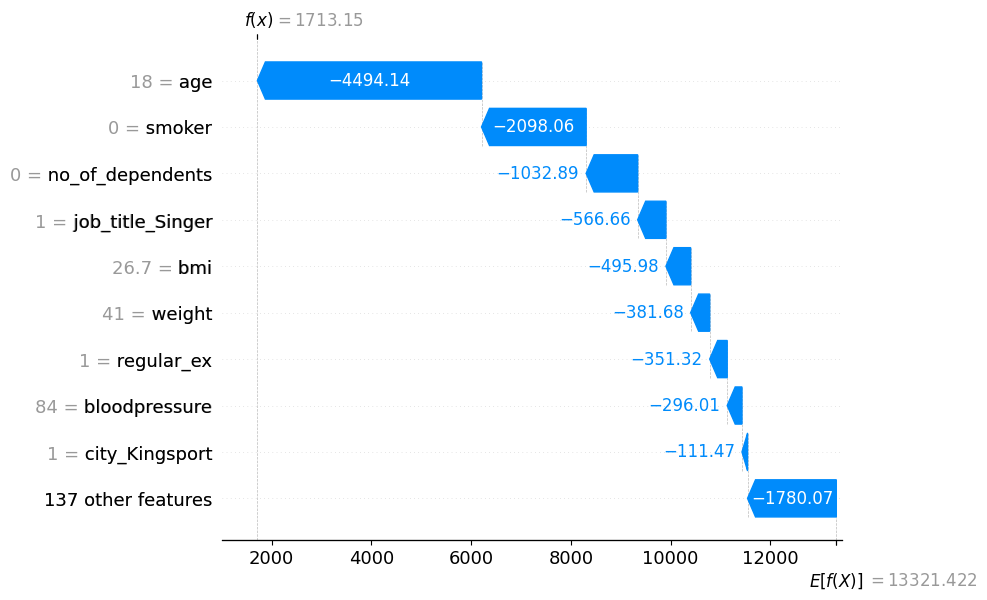

In [178]:
#display all feature contribution in a waterfall plot
#print(X.iloc[0])
#print(explanation)
shap.waterfall_plot(explanation)
#print the prediction that shap stored









In [ ]:

import shap
shap.initjs()
#use deep explainer

torch.no_grad()


X_train_1 = X_train.float()



example_instance = X[0]

#scale the example instance
example_instance = scaler.transform(example_instance)

#convert to tensor
example_instance = torch.tensor(example_instance, dtype=torch.float32)

#print(example_instance)

#add make instance to tensor of dimension 2
example_instance = example_instance.unsqueeze(0)

#print(example_instance)

#print(feature_names)



e = shap.DeepExplainer(model, X_train_1)
#calculate shap values with tolerance of 0.1
shap_values = e.shap_values(example_instance, check_additivity=False)
#print(shap_values)

#convert tensor to numpy array
shape_values.data = np.array(shap_values.data)
#convert [[a],[b]] to [a,b]
shape_values.data = shape_values.data.unsqueeze(-1)

print(shape_values.data)
#print("SHAP values:")
#print(len(shap_values))
#print(len(shap_values[0]))
#print(shap_values[0])

#print(e.expected_value[0])

#create explanation
explanation = shap.Explanation(values=shap_values, base_values=e.expected_value[0], data=X[10], feature_names=feature_names)
#print(explanation)
explanation = explanation[0]
print(explanation)

#create waterfall plot

shap.waterfall_plot(explanation, max_display=10)

In [185]:
from sklearn.inspection import PartialDependenceDisplay

#plot the partial dependence plot
PartialDependenceDisplay.from_estimator(model, X_train, 'age')


ValueError: Feature 'a' not in feature_names